# Pymatgen for Bands and DOS plots

This notebook details some basic examples for bands and dos plots. It uses mixed-metal oxides
as examples but can be adapted for other applications. This notebook is heavily dependent on
the pymatgen module in python3. The documentation for pymatgen can be found [here](https://pymatgen.org/).
The pymatgen module is fairly large and has a lot of functionality beyond the scope of band structures
and dos plots.

This notebook uses python3.8 for all calculations but should be backwards compatible.


> I would recommend using Jupyter notebooks when you are first plotting bands structure or DOS plots
> as it is easier to adjust properties and to experiment with different parameters. When you have a plot
> you are happy with you should make a regular python file for making your final figures.

First, install using pip3:

        pip3 install pymatgen

Then, import pymatgen as:

In [1]:
import pymatgen

---
## Band Structures


Band structure plotting requires two files: the vasprun.xml file and KPOINTS file. The k-path is taken
from the KPOINTS file and the bands are taken from the xml file. Although other parsers are available to
get properties from other files (OUTCAR, OSZICAR, PROCAR, *etc.*), these are less efficient for plotting band
structures and DOS plots and so are not discussed. More information on other parsers can be found
[here](https://pymatgen.org/pymatgen.io.vasp.outputs.html).

> I use here a basic band example for MnFe<sub>2</sub>O<sub>4</sub> which includes spin polarisation and as such has
a spin up and spin down band structure and DOS. This is somewhat a more complex example than a non-spin polarised calculation but
will highlight the full structure and functionality of the pymatgen module for band structure and DOS plots.

In pymatgen, the ```Vasprun``` class is used to parse xml files. For band structures, a special
class ```BSVasprun``` is available that discards all other information except the eigenvalues for band plots.
This highly optimized class is recommended for band structure plots but the more general ```Vasprun``` can also be used.
After defining an instance of ```BSVasprun```, the band structure can be obtained with the ```get_band_structure()``` method and
plotted with the ```BSPlotter``` class as follows.


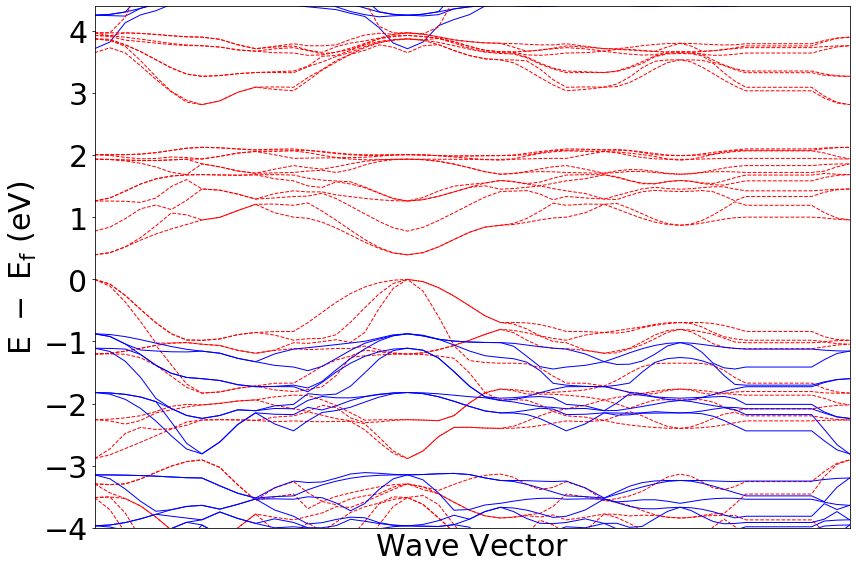

In [2]:
%matplotlib inline
from pymatgen.io.vasp.outputs import BSVasprun
from pymatgen.electronic_structure.plotter import BSPlotter

# parse projected eigenvalues only if you later want to plot an element decomposed band structure
vaspout = BSVasprun("../MnFe2O4/bands/vasprun.xml", parse_projected_eigen=True)
bandstr = vaspout.get_band_structure(line_mode=True)
bs_plt = BSPlotter(bandstr).get_plot()

As you can see, only a few lines of code are needed to get a nice band plot.

> The `parse_projected_eigen` keyword is set to `True` in order to be able to plot element-projected band structure
> plots as will be shown later. If you don't plan on making element-projected band structures feel free to omit this
> keyword

The other advantage of plotting
by this method is that the `get_plot()` method returns a matplotlib plot object and so a lot of matplotlib
functionality can be used for the band plots.

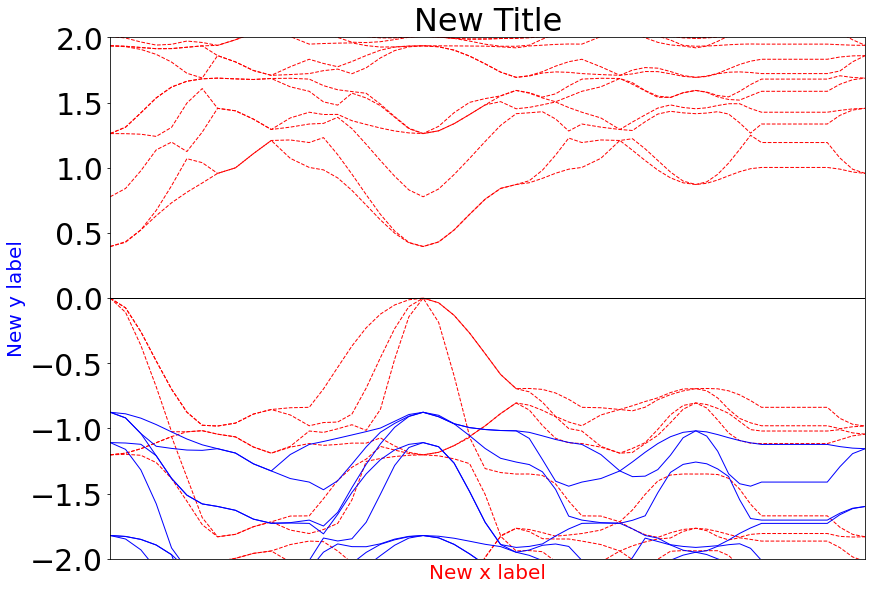

In [3]:
bs_plt = BSPlotter(bandstr).get_plot()

bs_plt.xlabel("New x label", fontsize=20, color="Red")
bs_plt.ylabel("New y label", fontsize=20, color="Blue")
bs_plt.title("New Title", fontsize=32)
bs_plt.ylim(-2, 2)
bs_plt.axhline(0, color="black", lw=1)

Unfortunately, you have to restate the `bs_plt = ...` statement every time you want to change some parameters.

There is no way to directly choose colours in the `BSPlotter` class. But, it is relatively simple to access the
matplotlib axis and then alter properties from there.

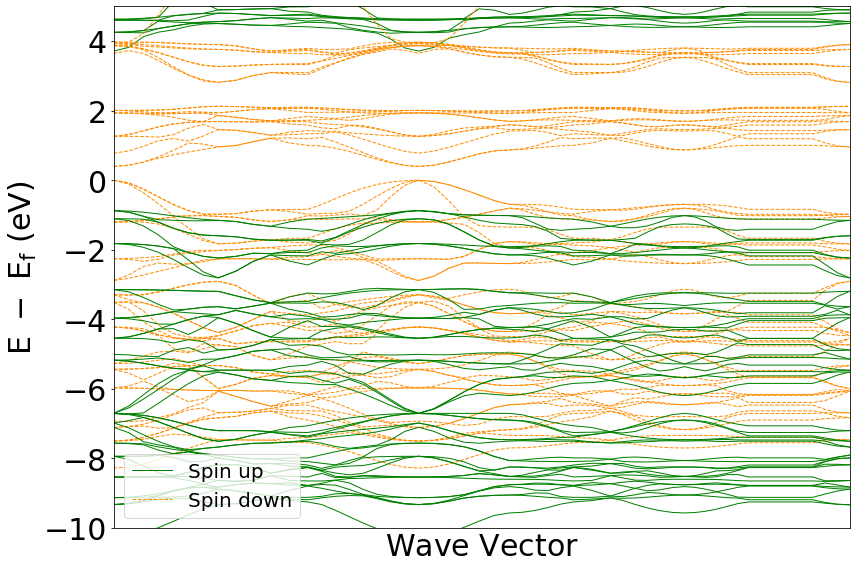

In [4]:
bs_plt = BSPlotter(bandstr).get_plot(ylim=[-10, 5])

# get axis object
ax = bs_plt.gca()

# A workaround for changing the colours of the lines in the plot
for i, line in enumerate(ax.get_lines()):
    if i % 2 == 0:
        line.set_color("Green")
    else:
        line.set_color("DarkOrange")

# A workaround for adding labels to the legend of the plot
ax.get_lines()[0].set_label("Spin up")
ax.get_lines()[1].set_label("Spin down")

bs_plt.legend(fontsize=20)


The only missing feature that can't be resolved with matplotlib is the high symmetry points along the k-path.
If you are using a KPOINTS file in your calculation that uses VASP's `Line_mode`, the high symmetry points
should be added automatically from the KPOINTS file (although you may have to adjust the labels).

If, like in this example, you have used a KPATH with explicit k-points (as you need to for, say, a hybrid DFT band
structure calculation), you need to use a quick workaround using pymatgen's `HighSymmKpath` class. This is used in the following
to make a new KPOINTS file with the `Line_mode` functionality that can be read by the `BSVasprun` class.

> Note that in this example the generation of the high symmetry k-path is done using the protocol developed by
> Setyawan and Curtarolo ([doi:10.1016/j.commatsci.2010.05.010](doi:10.1016/j.commatsci.2010.05.010)). Other protocols
> are available and are noted in the [documentation](https://pymatgen.org/pymatgen.symmetry.bandstructure.html).

In [5]:
from pymatgen.symmetry.bandstructure import HighSymmKpath
from pymatgen.io.vasp.inputs import Kpoints

k_path = HighSymmKpath(structure=vaspout.final_structure, path_type="sc")
kpts = Kpoints.automatic_linemode(divisions=50, ibz=k_path)

# write new k-point that uses Line_mode in VASP
kpts.write_file("./KPOINTS_LINE_MODE")

/home/robert/.local/lib/python3.8/site-packages/pymatgen/symmetry/kpath.py:179: UserWarning: The input structure does not match the expected standard primitive! The path can be incorrect. Use at your own risk.
  warn(


Then you can plot the band structure with the new KPOINTS file which will automatically include the high symmetry lines.

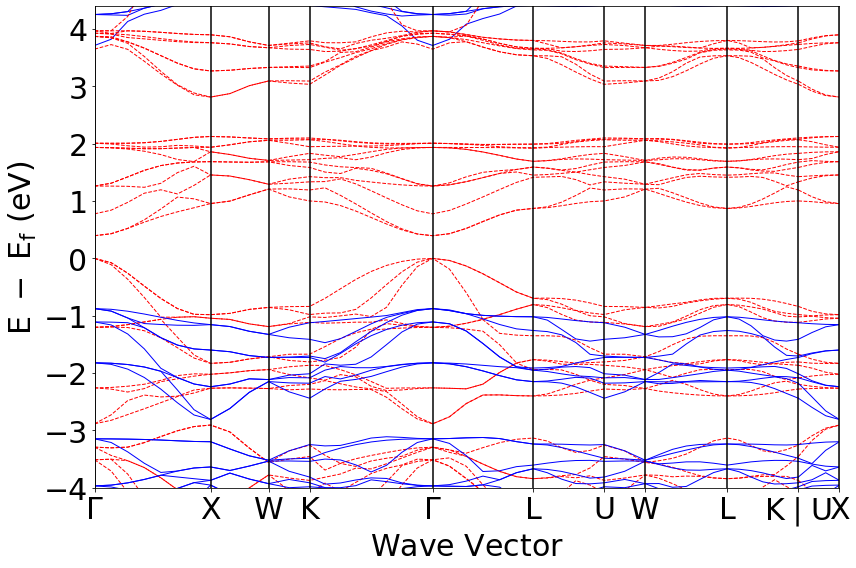

In [6]:
bandstr = vaspout.get_band_structure(kpoints_filename="./KPOINTS_LINE_MODE",
                                     line_mode=True)
plt = BSPlotter(bandstr).get_plot()

High symmetry lines are plotted last and so can be accessed as follows:

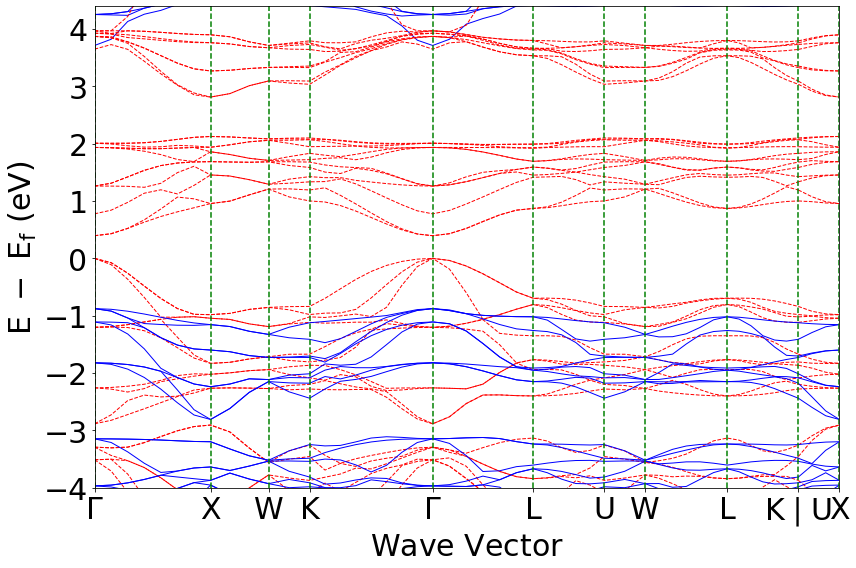

In [7]:
plt = BSPlotter(bandstr).get_plot()
ax = plt.gca()
for line in ax.lines[-12:]:
    line.set_color("green")
    line.set_linestyle("--")

The spin polarisation makes this a little more involved but in general all aspects of matplotlib
objects can be incorporated in here. You can also access the bands in the `bandstr` object fairly easily and using a couple
of loops plot everything manually.

(-10.0, 10.0)

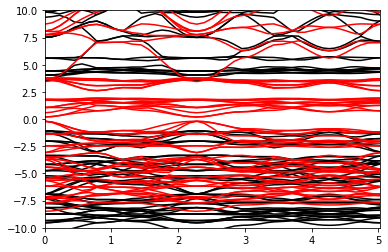

In [8]:
data = BSPlotter(bandstr).bs_plot_data()

colours = ["Black", "Red"]
for i, spin in enumerate(bandstr.bands):
    for band in bandstr.bands[spin]:
        plt.plot(bandstr.distance, band - bandstr.efermi, color=colours[i])

plt.xlim(0, max(bandstr.distance))
plt.ylim(-10, 10)

This takes up a bit more time to plot but makes the plot a bit more accessible.
I'm sure there are pros and cons for both methods but in general using the pymatgen BSPlotter is the easiest method
for nice band plots.

---
# DOS plots

In a similar vein as before, the Vasprun class can be used to load the dos from the vasprun.xml file. Plotting
is done in a slightly different way as an empty plot can be defined first and then different DOS objects can be
added.

/home/robert/.local/lib/python3.8/site-packages/pymatgen/io/vasp/outputs.py:888: UserWarning: No POTCAR file with matching TITEL fields was found in /home/robert/PycharmProjects/BandsandDOS/MnFe2O4/dos
  warnings.warn("No POTCAR file with matching TITEL fields"


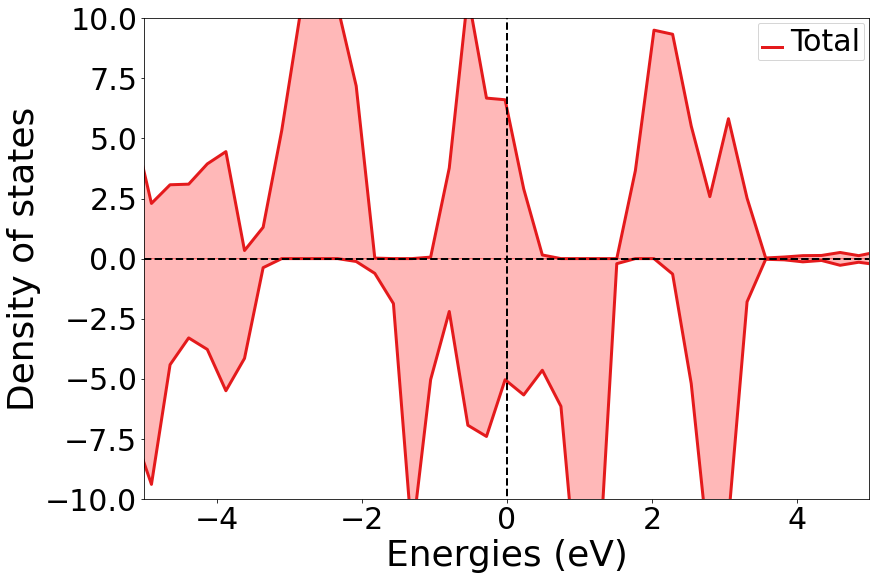

In [9]:
from pymatgen.io.vasp.outputs import Vasprun
from pymatgen.electronic_structure.plotter import DosPlotter
from matplotlib import pyplot as plt
from pymatgen.electronic_structure.core import Spin

dosrun = Vasprun("../MnFe2O4/dos/vasprun.xml")

# get the total dos
dos = dosrun.complete_dos

# here, the DosPlotter is constructed as
plotter = DosPlotter()
plotter.add_dos("Total", dos)

# get the plot as before and adjust properties with matplotlib
dos_plot = plotter.get_plot()
dos_plot.xlim(-5, 5)
dos_plot.ylim(-10, 10)

# add a light fill under the dos using matplotlib's fill_between method
ax = plt.gca()
for line in ax.lines:
    dos_plot.fill_between(dos.energies - dos.efermi, dos.densities[Spin.up], color="red", alpha=0.1)
    dos_plot.fill_between(dos.energies - dos.efermi, -dos.densities[Spin.down], color="red", alpha=0.1)

There are also methods that can be used on the `DosPlotter()` object that can add projected density of states
to the figure

(-10.0, 10.0)

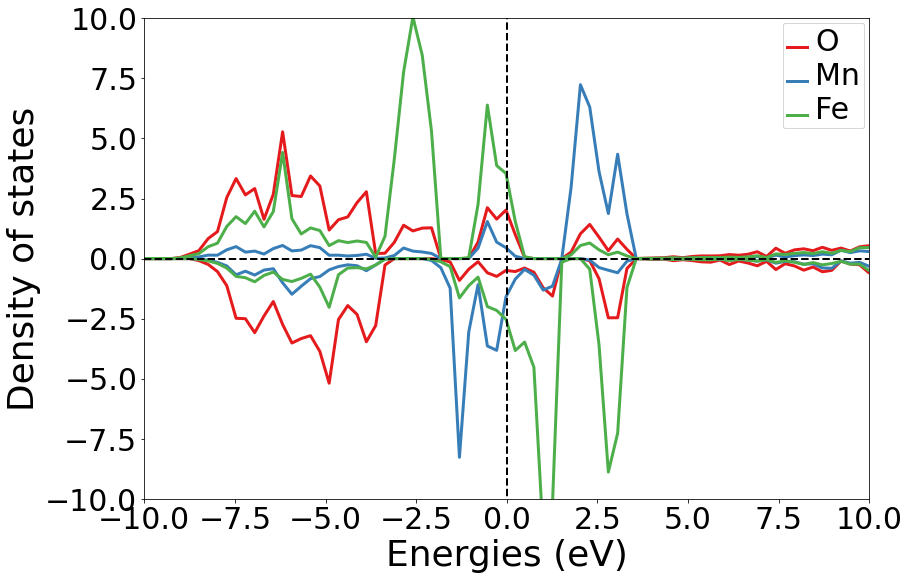

In [10]:
plotter = DosPlotter()

# get dos of each unique element in system
pdos = dos.get_element_dos()
plotter.add_dos_dict(pdos)

# plot dos
pdos_plot = plotter.get_plot()
pdos_plot.xlim(-10, 10)
pdos_plot.ylim(-10, 10)

Similarly, with orbital-projected density of states:

(-10.0, 10.0)

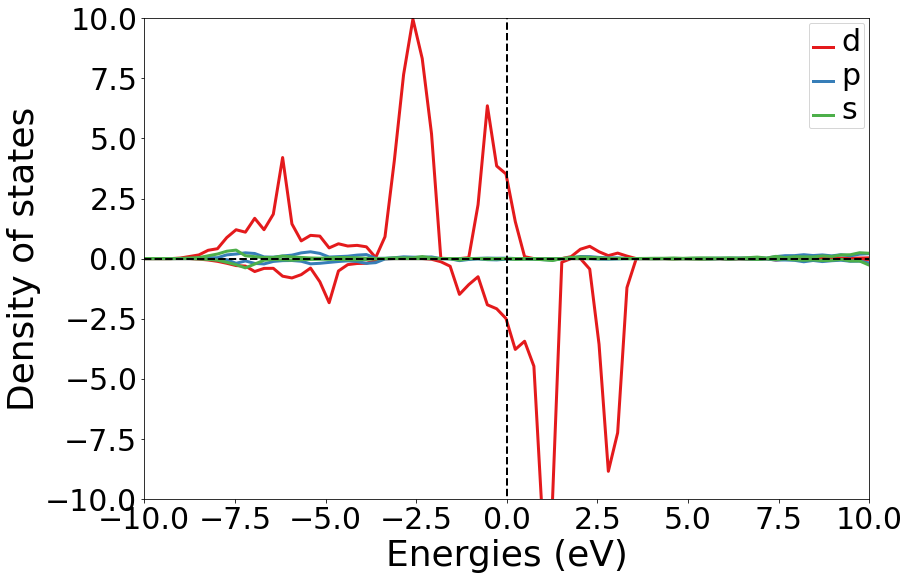

In [11]:
plotter = DosPlotter()

# get the s, p and d, orbital projected dos of Fe
pdos = dos.get_element_spd_dos("Fe")
plotter.add_dos_dict(pdos)

# plot dos
pdos_plot = plotter.get_plot()
pdos_plot.xlim(-10, 10)
pdos_plot.ylim(-10, 10)

and d-orbital projected:

(-10.0, 10.0)

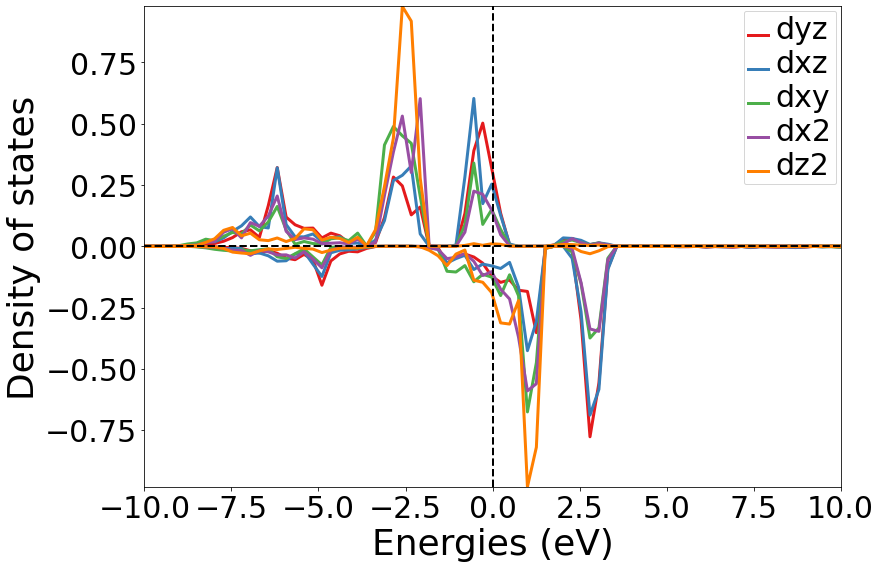

In [12]:
from pymatgen.electronic_structure.core import Orbital

plotter = DosPlotter()

# get dz2, dx2, dxy, dxz, dyz prokected dos for Fe on site 0
pdos1 = dos.get_site_orbital_dos(dosrun.final_structure.sites[0], Orbital.dz2)
pdos2 = dos.get_site_orbital_dos(dosrun.final_structure.sites[0], Orbital.dx2)
pdos3 = dos.get_site_orbital_dos(dosrun.final_structure.sites[0], Orbital.dxy)
pdos4 = dos.get_site_orbital_dos(dosrun.final_structure.sites[0], Orbital.dxz)
pdos5 = dos.get_site_orbital_dos(dosrun.final_structure.sites[0], Orbital.dyz)

plotter.add_dos("dz2", pdos1)
plotter.add_dos("dx2", pdos2)
plotter.add_dos("dxy", pdos3)
plotter.add_dos("dxz", pdos4)
plotter.add_dos("dyz", pdos5)

pdos_plot = plotter.get_plot()
pdos_plot.xlim(-10, 10)

It is probably cleaner and better coding practice to tidy these pdos objects into a dictionary, but for simplicity they
are stated explicitly as above.

---
## Bands and DOS

Bands and DOS plots can be combined in matplotlib using subplots. Or, alternatively, there is the `BSDOSPlotter` class
in pymatgen that can do this much more succinctly.

/home/robert/.local/lib/python3.8/site-packages/pymatgen/io/vasp/outputs.py:888: UserWarning: No POTCAR file with matching TITEL fields was found in /home/robert/Documents/new_MnFe2O4/Normal/New_cals/scf-mag
  warnings.warn("No POTCAR file with matching TITEL fields"
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


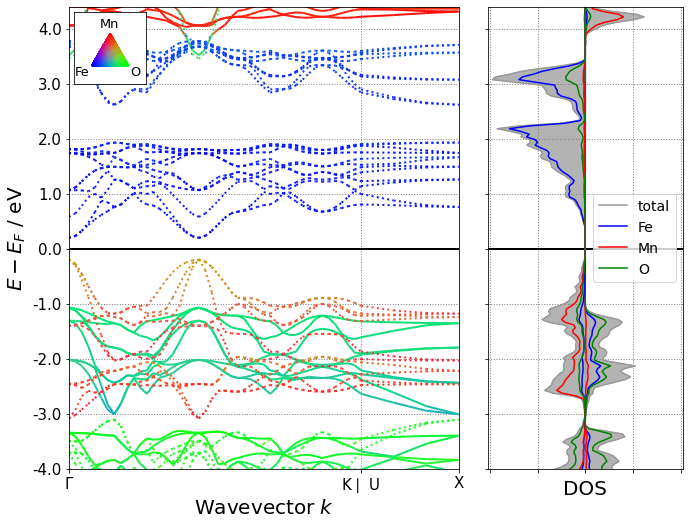

In [13]:
from pymatgen.electronic_structure.plotter import BSDOSPlotter
from pymatgen.io.vasp.outputs import Vasprun

dosrun = Vasprun("/home/robert/Documents/new_MnFe2O4/Normal/New_cals/scf-mag/vasprun.xml")
dos = dosrun.complete_dos

bsdosplot = BSDOSPlotter(
    bs_projection="elements",
    dos_projection="elements",
)

plt = bsdosplot.get_plot(bandstr, dos=dos)


It can take a bit of time for these plots to load. But with little effort, you can get a lot of information into
a single figure. It isn't possible to change the three colours in the plot unless you want to go to the effort
of writing your own function for the colouring of the bands. This is because of the way the colours are determined
and they seemingly can't be adjusted with a colour map. Objects can still be accessed with `plt.gca()` and so the adjustments
previously mentioned can also be used in these plots.

